In [5]:
import pandas as pd
import numpy as np # Umumnya tetap berguna

# URL untuk dataset multivariate Anda
url_multivariate = "https://raw.githubusercontent.com/adamzakys/SourceFiles/refs/heads/main/DatasetFinal/Dataset%20After%20Preprocessing/df_multivariate.csv"

# Membaca CSV dan menjadikan 'Tanggal' sebagai datetime, lalu urutkan
df_multi_nw = pd.read_csv(url_multivariate, parse_dates=['Tanggal']) # _nw untuk non-windowing
df_multi_nw = df_multi_nw.sort_values(by='Tanggal').reset_index(drop=True)

print("df_multi_nw (Multivariate Non-Windowing) berhasil dimuat:")
print(df_multi_nw.head())
print(f"Bentuk df_multi_nw: {df_multi_nw.shape}")
print(f"Kolom df_multi_nw: {df_multi_nw.columns.tolist()}")
print("-" * 30)

df_multi_nw (Multivariate Non-Windowing) berhasil dimuat:
     Tanggal     Price      Open      High       Low      Vol.  Change %  \
0 2018-01-01  0.099273  0.103213  0.101362  0.094943  0.000017  0.618706   
1 2018-01-02  0.111995  0.099272  0.114553  0.095496  0.000031  0.834955   
2 2018-01-03  0.115906  0.111994  0.115781  0.111601  0.000024  0.715310   
3 2018-01-04  0.116134  0.115904  0.115531  0.108323  0.000025  0.671275   
4 2018-01-05  0.133379  0.116133  0.131900  0.114074  0.000032  0.868237   

   EUR_German Unemployment Rate  CNY_CPI (YoY)  \
0                           0.4       0.419355   
1                           0.4       0.419355   
2                           0.4       0.419355   
3                           0.4       0.419355   
4                           0.4       0.419355   

   JPY_BoJ Interest Rate Decision  ...  USD_Core PCE Prices  \
0                             0.0  ...             0.416667   
1                             0.0  ...             0.41666

In [6]:
# Fungsi split_dataframe_minimal (SAMA SEPERTI SEBELUMNYA, bisa Anda definisikan sekali saja di awal notebook)
def split_dataframe_minimal(df, train_ratio=0.85, val_ratio=0.10):
    """Membagi DataFrame menjadi train, val, dan test secara kronologis (minimalis)."""
    total_rows = len(df)
    train_end_idx = int(total_rows * train_ratio)
    val_end_idx = int(total_rows * (train_ratio + val_ratio))

    train_df = df.iloc[:train_end_idx]
    val_df = df.iloc[train_end_idx:val_end_idx]
    test_df = df.iloc[val_end_idx:]
    
    return train_df, val_df, test_df

# Panggil fungsi split untuk df_multi_nw
# Pastikan df_multi_nw sudah dimuat dari Blok 1
if 'df_multi_nw' in locals() and not df_multi_nw.empty:
    train_df_mnw, val_df_mnw, test_df_mnw = split_dataframe_minimal(df_multi_nw) # _mnw untuk multivariate non-windowing

    # Cek hasilnya dengan informasi tanggal
    print("Pembagian DataFrame berhasil (Multivariate Non-Windowing):")

    if not train_df_mnw.empty:
        train_start_date = train_df_mnw['Tanggal'].min().strftime('%Y-%m-%d')
        train_end_date = train_df_mnw['Tanggal'].max().strftime('%Y-%m-%d')
        print(f"- Training   : {train_df_mnw.shape[0]} baris, dari {train_start_date} s.d. {train_end_date}")
    else:
        print(f"- Training   : {train_df_mnw.shape[0]} baris")

    if not val_df_mnw.empty:
        val_start_date = val_df_mnw['Tanggal'].min().strftime('%Y-%m-%d')
        val_end_date = val_df_mnw['Tanggal'].max().strftime('%Y-%m-%d')
        print(f"- Validation : {val_df_mnw.shape[0]} baris, dari {val_start_date} s.d. {val_end_date}")
    else:
        print(f"- Validation : {val_df_mnw.shape[0]} baris")

    if not test_df_mnw.empty:
        test_start_date = test_df_mnw['Tanggal'].min().strftime('%Y-%m-%d')
        test_end_date = test_df_mnw['Tanggal'].max().strftime('%Y-%m-%d')
        print(f"- Testing    : {test_df_mnw.shape[0]} baris, dari {test_start_date} s.d. {test_end_date}")
    else:
        print(f"- Testing    : {test_df_mnw.shape[0]} baris")
        
else:
    print("DataFrame df_multi_nw belum dimuat atau kosong. Pembagian data tidak dilakukan.")
    # Inisialisasi agar variabel ada jika df_multi_nw gagal dimuat
    train_df_mnw, val_df_mnw, test_df_mnw = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

print("-" * 30)

Pembagian DataFrame berhasil (Multivariate Non-Windowing):
- Training   : 2173 baris, dari 2018-01-01 s.d. 2023-12-13
- Validation : 256 baris, dari 2023-12-14 s.d. 2024-08-25
- Testing    : 128 baris, dari 2024-08-26 s.d. 2024-12-31
------------------------------


Blok 3: Persiapan Sekuens Input (X) dan Target (y)

In [7]:
import numpy as np

# Fungsi ini sekarang membuat "window" untuk data multivariat
def prepare_sequences_windowed_mv(df, feature_cols, target_col, date_col, 
                                  n_input_steps=30, n_output_steps=30):
    """
    Mempersiapkan sekuens X (data historis 30 hari) dan y (target 30 hari ke depan)
    dari data multivariat.
    """
    X_list, y_list, dates_X_list = [], [], []
    
    num_rows = len(df)
    for i in range(num_rows - n_input_steps - n_output_steps + 1):
        
        # Mengambil potongan 30 hari dari SEMUA fitur untuk input X
        X_sample = df.iloc[i : i + n_input_steps][feature_cols].values
        
        # Mengambil potongan 30 hari dari SATU fitur target ('Price') untuk output y
        y_sample = df.iloc[i + n_input_steps : i + n_input_steps + n_output_steps][target_col].values
        
        if len(X_sample) == n_input_steps and len(y_sample) == n_output_steps:
            X_list.append(X_sample)
            y_list.append(y_sample)
            dates_X_list.append(df.iloc[i + n_input_steps - 1][date_col]) 
            
    X_np = np.array(X_list, dtype=np.float32)
    y_np = np.array(y_list, dtype=np.float32)
    dates_X_np = np.array(dates_X_list)
    
    # Bentuk X_np sudah otomatis menjadi (sampel, 30, 20), tidak perlu reshape lagi
    return X_np, y_np, dates_X_np

# --- Aplikasi untuk Skenario Multivariat (Windowing) ---

# Definisikan parameter (Sama seperti kode asli Anda)
all_cols_mnw = df_multi_nw.columns.tolist()
feature_cols_mnw = [col for col in all_cols_mnw if col != 'Tanggal'] # Menggunakan variabel asli Anda
target_col_name = 'Price'
date_col_name = 'Tanggal'
N_INPUT_DAYS = 30
N_OUTPUT_DAYS = 30

# Inisialisasi variabel (Sama seperti kode asli Anda)
X_train_lstm_mnw, y_train_mnw, X_val_lstm_mnw, y_val_mnw, X_test_lstm_mnw, y_test_mnw = [np.array([])] * 6

# Pastikan DataFrame hasil split tidak kosong
if not train_df_mnw.empty and not val_df_mnw.empty and not test_df_mnw.empty:
    
    # Panggil fungsi windowing yang baru
    X_train_lstm_mnw, y_train_mnw, dates_X_train_mnw = prepare_sequences_windowed_mv(
        train_df_mnw, feature_cols_mnw, target_col_name, date_col_name, 
        n_input_steps=N_INPUT_DAYS, n_output_steps=N_OUTPUT_DAYS
    )
    X_val_lstm_mnw, y_val_mnw, dates_X_val_mnw = prepare_sequences_windowed_mv(
        val_df_mnw, feature_cols_mnw, target_col_name, date_col_name, 
        n_input_steps=N_INPUT_DAYS, n_output_steps=N_OUTPUT_DAYS
    )
    X_test_lstm_mnw, y_test_mnw, dates_X_test_mnw = prepare_sequences_windowed_mv(
        test_df_mnw, feature_cols_mnw, target_col_name, date_col_name, 
        n_input_steps=N_INPUT_DAYS, n_output_steps=N_OUTPUT_DAYS
    )

    # --- BLOK RESHAPE DIHAPUS ---
    # Karena data sudah 3D (sampel, 30, 20) dari fungsi di atas.

    print("Persiapan sekuens untuk model LSTM Multivariat (Windowing) Selesai:")
    print(f"- Training   X: {X_train_lstm_mnw.shape}, y: {y_train_mnw.shape}")
    print(f"- Validation X: {X_val_lstm_mnw.shape}, y: {y_val_mnw.shape}")
    print(f"- Testing    X: {X_test_lstm_mnw.shape}, y: {y_test_mnw.shape}")
else:
    print("Salah satu DataFrame (train, val, test) kosong. Proses persiapan sekuens dilewati.")

print("-" * 30)

Persiapan sekuens untuk model LSTM Multivariat (Windowing) Selesai:
- Training   X: (2114, 30, 20), y: (2114, 30)
- Validation X: (197, 30, 20), y: (197, 30)
- Testing    X: (69, 30, 20), y: (69, 30)
------------------------------


In [8]:
import tensorflow as tf
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Fungsi untuk mengatur random seed agar hasil bisa direproduksi
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.config.experimental.enable_op_determinism()

# Panggil fungsi ini untuk memastikan konsistensi
set_seeds()
print("Random seed telah diatur untuk memastikan hasil yang dapat direproduksi.")

def build_lstm_model(input_shape, output_size, num_units, dropout_rate, learning_rate):
    """Membangun arsitektur model LSTM."""
    model = Sequential([
        LSTM(num_units, return_sequences=True, input_shape=input_shape, activation='tanh'),
        Dropout(dropout_rate),
        LSTM(num_units, return_sequences=False, activation='tanh'),
        Dropout(dropout_rate),
        Dense(output_size, activation='linear')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model

print("Fungsi build_lstm_model berhasil didefinisikan.")
print("-" * 30)

Random seed telah diatur untuk memastikan hasil yang dapat direproduksi.
Fungsi build_lstm_model berhasil didefinisikan.
------------------------------


In [9]:
import itertools
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

# Ruang pencarian hyperparameter (final)
param_grid = {
    'units': [50, 75, 100],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'dropout_rate': [0.1, 0.2]
}

# Epochs maksimal dan patience untuk EarlyStopping (final)
EPOCHS_MAX = 200
PATIENCE = 15 # Menggunakan nilai patience yang telah kita diskusikan

# Buat semua kombinasi dari hyperparameter
all_combinations = list(itertools.product(
    param_grid['units'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['dropout_rate']
))

print(f"Total kombinasi hyperparameter yang akan diuji: {len(all_combinations)}")

# List untuk menyimpan hasil dari setiap kombinasi
history_results_mnw = []

# Pastikan data training ada sebelum memulai loop
if 'X_train_lstm_mnw' in locals() and X_train_lstm_mnw.size > 0:
    # Loop untuk grid search
    for idx, params in enumerate(all_combinations):
        units, lr, batch_size, dropout = params
        
        print(f"\n--- Menguji Kombinasi {idx + 1}/{len(all_combinations)} ---")
        print(f"Params: Units={units}, LR={lr}, BatchSize={batch_size}, Dropout={dropout}")

        # Bangun model dengan hyperparameter saat ini
        # Input shape untuk multivariat non-windowing adalah (1, jumlah_fitur)
        model_mnw = build_lstm_model(
            input_shape=(X_train_lstm_mnw.shape[1], X_train_lstm_mnw.shape[2]),
            output_size=y_train_mnw.shape[1],
            num_units=units,
            dropout_rate=dropout,
            learning_rate=lr
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)

        history = model_mnw.fit(
            X_train_lstm_mnw, y_train_mnw,
            epochs=EPOCHS_MAX,
            batch_size=batch_size,
            validation_data=(X_val_lstm_mnw, y_val_mnw),
            callbacks=[early_stopping],
            verbose=0,
            shuffle=False
        )
        
        best_val_loss = min(history.history['val_loss'])
        actual_epochs = early_stopping.stopped_epoch if early_stopping.stopped_epoch > 0 else EPOCHS_MAX

        print(f"Selesai pada epoch: {actual_epochs}. Val Loss Terbaik: {best_val_loss:.6f}")

        history_results_mnw.append({
            'combination': idx + 1,
            'units': units,
            'learning_rate': lr,
            'batch_size': batch_size,
            'dropout_rate': dropout,
            'best_val_loss': best_val_loss,
            'stopped_epoch': actual_epochs
        })

    print("\n--- Pencarian Hyperparameter Selesai ---")

else:
    print("Variabel data training (X_train_lstm_mnw) tidak ditemukan atau kosong. Proses dilewati.")

Total kombinasi hyperparameter yang akan diuji: 54

--- Menguji Kombinasi 1/54 ---
Params: Units=50, LR=0.0001, BatchSize=16, Dropout=0.1


d:\experiment after testing - Copy\Code Penelitian new\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Selesai pada epoch: 102. Val Loss Terbaik: 0.013319

--- Menguji Kombinasi 2/54 ---
Params: Units=50, LR=0.0001, BatchSize=16, Dropout=0.2
Selesai pada epoch: 27. Val Loss Terbaik: 0.037704

--- Menguji Kombinasi 3/54 ---
Params: Units=50, LR=0.0001, BatchSize=32, Dropout=0.1
Selesai pada epoch: 37. Val Loss Terbaik: 0.015267

--- Menguji Kombinasi 4/54 ---
Params: Units=50, LR=0.0001, BatchSize=32, Dropout=0.2
Selesai pada epoch: 60. Val Loss Terbaik: 0.028675

--- Menguji Kombinasi 5/54 ---
Params: Units=50, LR=0.0001, BatchSize=64, Dropout=0.1
Selesai pada epoch: 90. Val Loss Terbaik: 0.031846

--- Menguji Kombinasi 6/54 ---
Params: Units=50, LR=0.0001, BatchSize=64, Dropout=0.2
Selesai pada epoch: 111. Val Loss Terbaik: 0.024474

--- Menguji Kombinasi 7/54 ---
Params: Units=50, LR=0.001, BatchSize=16, Dropout=0.1
Selesai pada epoch: 21. Val Loss Terbaik: 0.008698

--- Menguji Kombinasi 8/54 ---
Params: Units=50, LR=0.001, BatchSize=16, Dropout=0.2
Selesai pada epoch: 21. Val Loss T

Blok 6: Analisis Hasil Pencarian Hyperparameter & Penyimpanan ke CSV

In [10]:
import pandas as pd

# Pastikan history_results_mnw dari blok sebelumnya sudah terisi
if 'history_results_mnw' in locals() and history_results_mnw:
    # Konversi hasil ke DataFrame untuk analisis mudah
    results_df_mnw = pd.DataFrame(history_results_mnw)
    
    # Urutkan DataFrame berdasarkan validation loss terbaik (terendah)
    results_df_mnw = results_df_mnw.sort_values(by='best_val_loss', ascending=True)

    print("\n--- Analisis Hasil Pencarian Hyperparameter (Multivariat Non-Windowing) ---")
    print("\nTop 5 Kombinasi Hyperparameter Terbaik (berdasarkan Validation Loss):")
    # Menggunakan .to_string() agar semua kolom ditampilkan dengan rapi
    print(results_df_mnw.head(5).to_string())

    # Menyimpan hasil lengkap ke file CSV untuk dokumentasi
    output_filename_mnw = 'grid_search_results_multivariate_nonwindowing.csv'
    results_df_mnw.to_csv(output_filename_mnw, index=False)
    print(f"\nHasil lengkap dari {len(all_combinations)} kombinasi disimpan ke '{output_filename_mnw}'")

else:
    print("Tidak ada hasil pencarian hyperparameter (history_results_mnw) untuk dianalisis.")
    # Inisialisasi results_df_mnw kosong jika tidak ada hasil
    results_df_mnw = pd.DataFrame()

print("-" * 30)


--- Analisis Hasil Pencarian Hyperparameter (Multivariat Non-Windowing) ---

Top 5 Kombinasi Hyperparameter Terbaik (berdasarkan Validation Loss):
    combination  units  learning_rate  batch_size  dropout_rate  best_val_loss  stopped_epoch
53           54    100          0.010          64           0.2       0.004455             43
16           17     50          0.010          64           0.1       0.006617             19
35           36     75          0.010          64           0.2       0.007281             21
9            10     50          0.001          32           0.2       0.008492             40
6             7     50          0.001          16           0.1       0.008698             21

Hasil lengkap dari 54 kombinasi disimpan ke 'grid_search_results_multivariate_nonwindowing.csv'
------------------------------


Hasil grid search berhasil dimuat dari 'grid_search_results_multivariate_nonwindowing.csv'

--- Hyperparameter Terbaik Terpilih ---
   combination  units  learning_rate  batch_size  dropout_rate  best_val_loss  stopped_epoch
0         54.0  100.0           0.01        64.0           0.2       0.004455           43.0
--------------------------------------------------

Membangun model final dengan hyperparameter terbaik...


d:\experiment after testing - Copy\Code Penelitian new\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_110 (LSTM)                 │ (None, 30, 100)        │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_111 (LSTM)                 │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,830 (514.96 KB)

 Trainable params: 131,830 (514.96 KB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Pelatihan Model Final ---
Epoch 1/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0201 - mse: 0.0201
Epoch 1: val_loss improved from inf to 0.14299, saving model to final_model_multivariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.1430 - val_mse: 0.1430
Epoch 2/43
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0215 - mse: 0.0215
Epoch 2: val_loss improved from 0.14299 to 0.12923, saving model to final_model_multivariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.1292 - val_mse: 0.1292
Epoch 3/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0188 - mse: 0.0188
Epoch 3: val_loss improved from 0.12923 to 0.11833, saving model to final_model_multivariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.1183 - val_mse: 0.1183
Epoch 4/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0162 - mse: 0.0162
Epoch 4: val_loss improved from 0.11833 to 0.04017, saving model to final_model_multivariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 5/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0112 - mse: 0.0112
Epoch 5: val_loss did not improve from 0.04017
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 6/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0117 - mse: 0.0117
Epoch 6: val_loss improved from 0.04017 to 0.01527, saving model to final_model_multivariate_nonwindowing.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 7/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0703 - mse: 0.0703
Epoch 7: val_loss did not improve from 0.01527
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0680 - mse: 0.0680 - val_loss: 0.1059 - val_mse: 0.1059
Epoch 8/43
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0204 - mse: 0.0204
Epoch 8: val_loss did not improve from 0.01527
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.1008 - val_mse: 0.1008
Epoch 9/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0234 - mse: 0.0234
Epoch 9: val_loss did not improve from 0.01527
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 10/43
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0203 - mse: 0.0203
Epoch 10: val_loss did not improve from 0.01527
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0213 - mse: 0.02

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 14/43
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0250 - mse: 0.0250
Epoch 14: val_loss did not improve from 0.00799
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 15/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0302 - mse: 0.0302
Epoch 15: val_loss did not improve from 0.00799
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 16/43
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0189 - mse: 0.0189
Epoch 16: val_loss did not improve from 0.00799
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.1680 - val_mse: 0.1680
Epoch 17/43
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0124 - mse: 0.0124
Epoch 17: val_loss did not improve from 0.00799
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0126 - mse

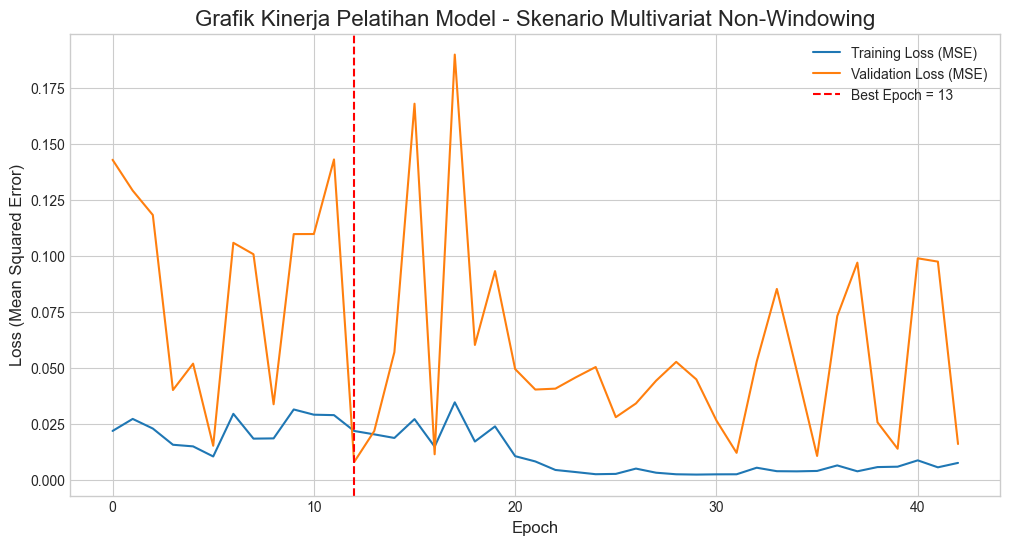


Memuat model terbaik dari file: final_model_multivariate_nonwindowing.h5
Model terbaik berhasil dimuat.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf

# Nama file CSV tempat hasil grid search disimpan
grid_search_results_file = 'grid_search_results_multivariate_nonwindowing.csv'

try:
    # 1. Muat hasil grid search dari file CSV
    results_df_mnw = pd.read_csv(grid_search_results_file)
    print(f"Hasil grid search berhasil dimuat dari '{grid_search_results_file}'")

    # 2. Ambil hyperparameter terbaik dari baris pertama (diasumsikan sudah terurut)
    best_params_mnw = results_df_mnw.iloc[0]
    print("\n--- Hyperparameter Terbaik Terpilih ---")
    print(best_params_mnw.to_frame().T.to_string())
    print("-" * 50)

    # 3. Bangun dan Latih Model Final
    print("\nMembangun model final dengan hyperparameter terbaik...")
    final_model_mnw = build_lstm_model(
        input_shape=(X_train_lstm_mnw.shape[1], X_train_lstm_mnw.shape[2]),
        output_size=y_train_mnw.shape[1],
        num_units=int(best_params_mnw['units']),
        dropout_rate=best_params_mnw['dropout_rate'],
        learning_rate=best_params_mnw['learning_rate']
    )
    final_model_mnw.summary()

    # Definisikan callbacks
    final_model_path_mnw = 'final_model_multivariate_nonwindowing.h5'
    early_stopping_final = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint_final = ModelCheckpoint(filepath=final_model_path_mnw, monitor='val_loss', save_best_only=True, verbose=1)
    # Ambil jumlah epoch terbaik dari hasil grid search
    best_epoch_from_search = int(best_params_mnw['stopped_epoch'])

    
    # Latih model final
    print("\n--- Memulai Pelatihan Model Final ---")
    history_final_mnw = final_model_mnw.fit(
        X_train_lstm_mnw, y_train_mnw,
        # epochs=EPOCHS_MAX,
        epochs=best_epoch_from_search,
        batch_size=int(best_params_mnw['batch_size']),
        validation_data=(X_val_lstm_mnw, y_val_mnw),
        # callbacks=[early_stopping_final, model_checkpoint_final],
        callbacks=[model_checkpoint_final],
        verbose=1,
        shuffle=False
    )

    # Plot Grafik Kinerja Pelatihan
    print("\n--- Membuat Grafik Kinerja Pelatihan (Loss vs Epoch) ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    plt.plot(history_final_mnw.history['loss'], label='Training Loss (MSE)')
    plt.plot(history_final_mnw.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Grafik Kinerja Pelatihan Model - Skenario Multivariat Non-Windowing', fontsize=16)
    plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    best_epoch = np.argmin(history_final_mnw.history['val_loss']) + 1
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch = {best_epoch}')
    plt.legend()
    plt.show()

    # Muat kembali model terbaik yang disimpan
    print(f"\nMemuat model terbaik dari file: {final_model_path_mnw}")
    final_model_mnw = load_model(
        final_model_path_mnw, 
        custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
    )
    print("Model terbaik berhasil dimuat.")

except FileNotFoundError:
    print(f"ERROR: File hasil grid search '{grid_search_results_file}' tidak ditemukan.")
    print("Harap jalankan blok kode pencarian hyperparameter terlebih dahulu untuk menghasilkan file ini.")
except Exception as e:
    print(f"Terjadi error: {e}")

--- Memulai Evaluasi Final, Prediksi, dan Analisis Error (Multivariat Non-Windowing) ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
- Test MSE (Skala Ternormalisasi): 0.012488
- Detail prediksi untuk 69 sampel disimpan ke 'detailed_predictions_multivariate_nonwindowing.csv'

--- Analisis Rata-rata Error per Hari Prediksi (30 Hari Horizon) ---
- Prediksi paling akurat (MSE terendah) terjadi pada : Hari ke-3
- Prediksi paling tidak akurat (MSE tertinggi) terjadi pada: Hari ke-28


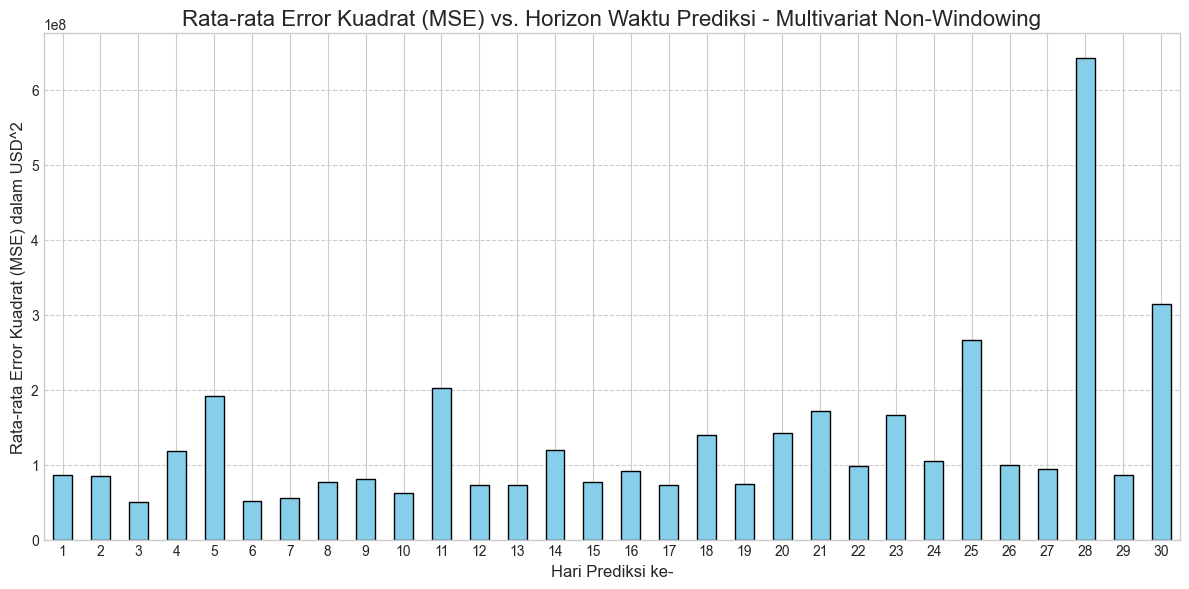


--- Visualisasi Grafik Sampel Prediksi vs Aktual ---


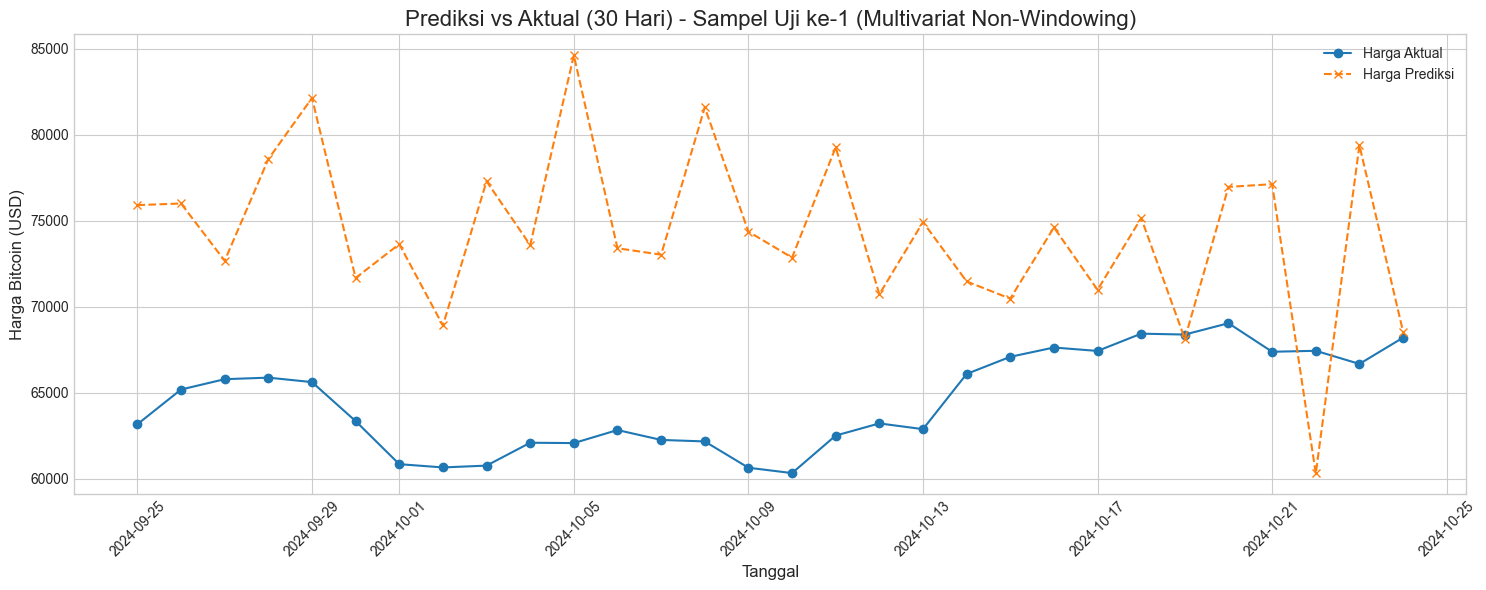

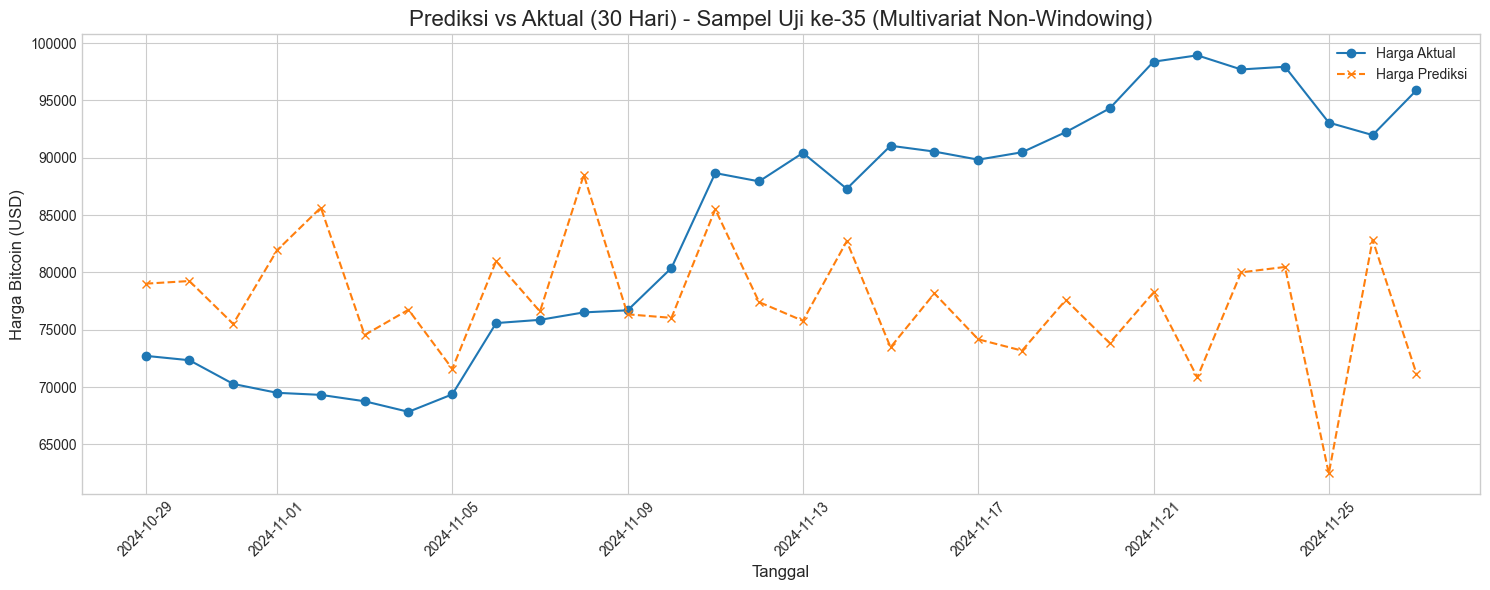

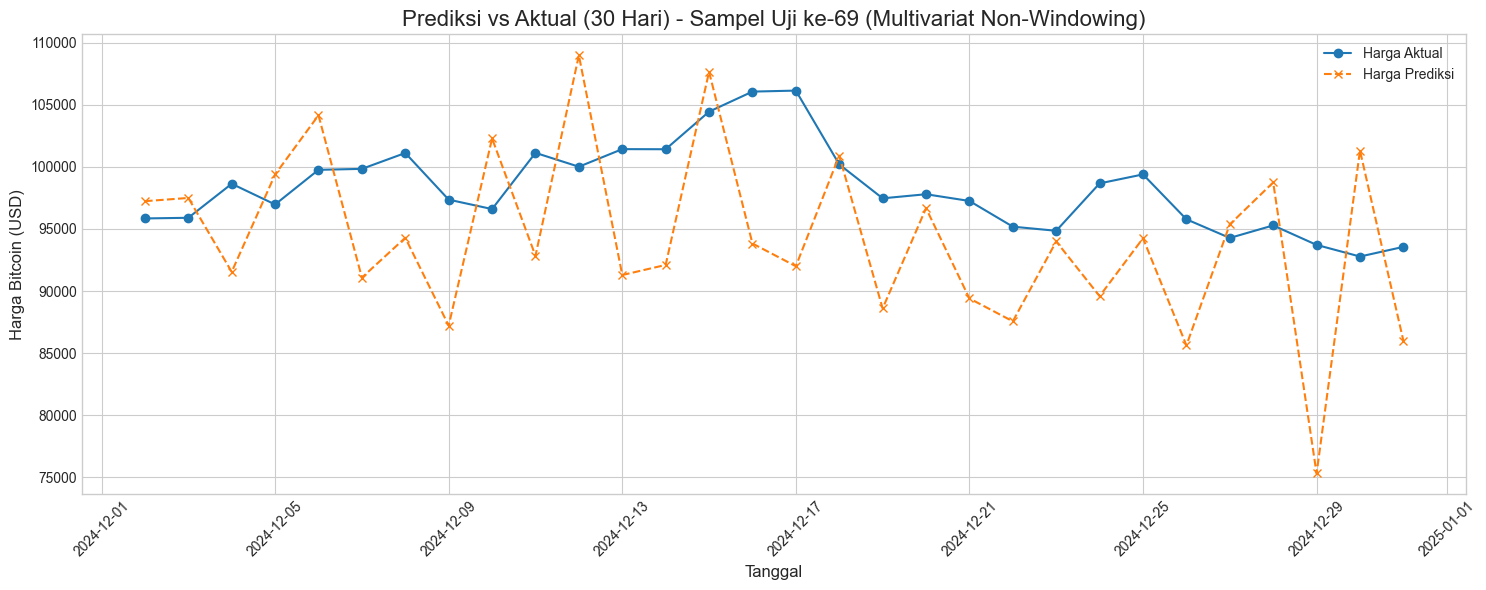

------------------------------
Proses untuk Skenario Multivariat Non-Windowing Selesai.


In [17]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan variabel dari blok sebelumnya sudah ada
if 'final_model_mnw' in locals() and 'X_test_lstm_mnw' in locals():
    print("--- Memulai Evaluasi Final, Prediksi, dan Analisis Error (Multivariat Non-Windowing) ---")

    try:
        # 1. Lakukan Prediksi dan Denormalisasi
        scaler_target_path = '../scaler_target.pkl'
        scaler_target = joblib.load(scaler_target_path)
        y_pred_scaled = final_model_mnw.predict(X_test_lstm_mnw)
        y_pred_denorm = scaler_target.inverse_transform(y_pred_scaled)
        y_test_denorm = scaler_target.inverse_transform(y_test_mnw)
        
        # 2. Hitung MSE Keseluruhan pada Data Uji
        # mse_real_scale = mean_squared_error(y_test_denorm, y_pred_denorm)
        # print(f"\n- Test MSE Keseluruhan (Skala Asli USD^2): {mse_real_scale:,.2f}")
        mse_normalized = mean_squared_error(y_test_mnw, y_pred_scaled)
        print(f"- Test MSE (Skala Ternormalisasi): {mse_normalized:.6f}")

        
        # 3. Simpan dan Analisis Detail Prediksi per Sampel
        all_predictions_list = []
        for i in range(len(X_test_lstm_mnw)):
            start_date = pd.to_datetime(dates_X_test_mnw[i]) + pd.Timedelta(days=1)
            date_range = pd.date_range(start=start_date, periods=N_OUTPUT_DAYS)
            
            sample_df = pd.DataFrame({
                'Sample_Uji_ke': i + 1,
                'Hari_Prediksi_ke': np.arange(1, N_OUTPUT_DAYS + 1),
                'Tanggal': date_range,
                'Harga_Aktual': y_test_denorm[i],
                'Harga_Prediksi': y_pred_denorm[i]
            })
            all_predictions_list.append(sample_df)
            
        all_predictions_df = pd.concat(all_predictions_list, ignore_index=True)
        # REVISI: Hitung error kuadrat untuk MSE
        all_predictions_df['Error_Kuadrat'] = (all_predictions_df['Harga_Prediksi'] - all_predictions_df['Harga_Aktual'])**2
        
        output_predictions_file = 'detailed_predictions_multivariate_nonwindowing.csv'
        all_predictions_df.to_csv(output_predictions_file, index=False, float_format='%.2f')
        print(f"- Detail prediksi untuk {len(X_test_lstm_mnw)} sampel disimpan ke '{output_predictions_file}'")

        # 4. Analisis Rata-rata Error Kuadrat (MSE) per Hari Prediksi
        print("\n--- Analisis Rata-rata Error per Hari Prediksi (30 Hari Horizon) ---")
        # REVISI: Menghitung MSE per hari
        mse_per_day = all_predictions_df.groupby('Hari_Prediksi_ke')['Error_Kuadrat'].mean()
        
        min_error_day = mse_per_day.idxmin()
        max_error_day = mse_per_day.idxmax()
        
        print(f"- Prediksi paling akurat (MSE terendah) terjadi pada : Hari ke-{min_error_day}")
        print(f"- Prediksi paling tidak akurat (MSE tertinggi) terjadi pada: Hari ke-{max_error_day}")
        
        # Visualisasi Kurva Error
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(12, 6))
        mse_per_day.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Rata-rata Error Kuadrat (MSE) vs. Horizon Waktu Prediksi - Multivariat Non-Windowing', fontsize=16)
        plt.xlabel('Hari Prediksi ke-', fontsize=12)
        plt.ylabel('Rata-rata Error Kuadrat (MSE) dalam USD^2', fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

        # 5. Visualisasi Grafik Sampel (seperti sebelumnya)
        print("\n--- Visualisasi Grafik Sampel Prediksi vs Aktual ---")
        sample_indices_to_plot = [0, len(X_test_lstm_mnw) // 2, len(X_test_lstm_mnw) - 1]
        for sample_index in sample_indices_to_plot:
            plot_df = all_predictions_df[all_predictions_df['Sample_Uji_ke'] == sample_index + 1]
            plt.figure(figsize=(15, 6))
            plt.plot(plot_df['Tanggal'], plot_df['Harga_Aktual'], label='Harga Aktual', marker='o')
            plt.plot(plot_df['Tanggal'], plot_df['Harga_Prediksi'], label='Harga Prediksi', marker='x', linestyle='--')
            plt.title(f'Prediksi vs Aktual (30 Hari) - Sampel Uji ke-{sample_index+1} (Multivariat Non-Windowing)', fontsize=16)
            plt.ylabel('Harga Bitcoin (USD)', fontsize=12)
            plt.xlabel('Tanggal', fontsize=12)
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Terjadi error pada proses evaluasi atau visualisasi: {e}")
else:
    print("Model atau data uji tidak tersedia untuk dievaluasi.")

print("-" * 30)
print("Proses untuk Skenario Multivariat Non-Windowing Selesai.")

In [18]:
# Simpan data rata-rata error per hari prediksi (MSE vs Horizon Waktu) ke CSV
mse_per_day.to_csv('mse_per_day_multivariate_nonwindowing.csv', header=True)
print("Data rata-rata error per hari prediksi telah disimpan ke 'mse_per_day_multivariate_nonwindowing.csv'")

Data rata-rata error per hari prediksi telah disimpan ke 'mse_per_day_multivariate_nonwindowing.csv'
